# Introduction
dataset: https://archive.ics.uci.edu/ml/datasets/Census+Income 

In [ ]:
from google.colab import drive
#link to download the dataset
#

drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/MML/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/MML


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

dataset = pd.read_csv("adult.data", header=None, skipinitialspace=True, delimiter=',')
dataset_t = pd.read_csv("adult.test", header=None, skipinitialspace=True, delimiter=',', skiprows=1)

numeric_features = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week','income']
# Identify Categorical features
cate_features = ['workclass','education','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native']
dataset.columns = ['age','workclass','fnlwgt','education','education.num','marital.status', 'occupation','relationship', 'race', 
                   'sex', 'capital.gain','capital.loss', 'hours.per.week', 'native', 'income']
dataset_t.columns = ['age','workclass','fnlwgt','education','education.num','marital.status', 'occupation','relationship', 'race', 
                        'sex', 'capital.gain','capital.loss', 'hours.per.week', 'native', 'income']
dataset.isnull().sum().sum() # No missing values
dataset_test = dataset_t.copy()
dataset[dataset['education.num']==11].head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
48,41,State-gov,101603,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
49,29,Private,271466,Assoc-voc,11,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,43,United-States,<=50K
57,35,Private,56352,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,Puerto-Rico,<=50K
90,57,Private,249977,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


# Data Preparation

In [ ]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Combine majority class with upsampled minority class
dataset.replace(to_replace='?',value=np.nan,inplace=True)
dataset.isnull().sum()
dataset.dropna(axis=0,inplace=True)
dataset_test.replace(to_replace='?',value=np.nan,inplace=True)
dataset_test.dropna(axis=0,inplace=True)
dataset_test.isnull().sum()
dataset['income']=dataset['income'].map({'<=50K': 0, '>50K': 1})
dataset_test['income']=dataset_t['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
dataset.isnull().sum().sum()
# remove semantic error
dataset = dataset.loc[~((dataset.relationship=='Wife') & (dataset.sex == 'Male')), :]
dataset = dataset.loc[~(dataset['capital.gain']>40000), :]
df_clean = dataset.copy()
dft_clean = dataset_test.copy()
# prepare dataset manually feature engeneered
dataset["marital.status"] = dataset["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
dataset["marital.status"] = dataset["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
dataset_test["marital.status"] = dataset_test["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
dataset_test["marital.status"] = dataset_test["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
def get_investment(x1,x2):
    if x1 != 0 or x2!= 0:
      return 1
    else:
      return 0
dataset['capital']=dataset.apply(lambda x: get_investment(x['capital.gain'], x['capital.loss']), axis=1)
dataset_test['capital']=dataset_test.apply(lambda x: get_investment(x['capital.gain'], x['capital.loss']), axis=1)
dataset_pruned = dataset.drop(['fnlwgt','education', 'occupation', 'native', 'capital.loss', 
                               'capital.gain','relationship'], axis=1)
datasett_pruned = dataset_test.drop(['fnlwgt','education', 'occupation', 'native', 'capital.loss', 
                               'capital.gain','relationship'], axis=1)
le = LabelEncoder()
for i in [ 'workclass','marital.status', 'race', 'sex']:
    dataset_pruned[i]=le.fit_transform(dataset_pruned[i])
    datasett_pruned[i]=le.transform(datasett_pruned[i])

dataset_test.dropna(axis=0,inplace=True)
#prepare dataset with all features
for i in cate_features:
    df_clean[i]=le.fit_transform(df_clean[i])
    dft_clean[i]=le.transform(dft_clean[i])


df_majority = df_clean[df_clean.income==0]
df_minority = df_clean[df_clean.income==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
dfu_clean = pd.concat([df_majority, df_minority_upsampled])


# Data Exploration
 - label count
 - age and income
 - sex and income
 - education and income
 - race and income
 - race-education and income
 - sex-marital status and income

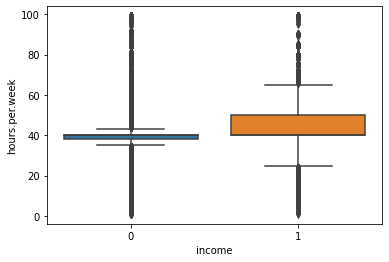

In [ ]:
from scipy.stats import chi2_contingency, chi2, ttest_ind
from scipy import stats
import random

sns.countplot(dataset['income'],label="Count")
plt.show()
# education is for sure a factor
g = sns.catplot(x="education.num",y="income",data=dataset,kind="bar",aspect=2,height= 5,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

# Age is a factor
sns.boxplot(y='hours.per.week',x='income',data=dataset)
sns.boxplot(y='age',x='income',data=dataset)

# Race is a factor
g = sns.catplot(x="race",y="income",data=dataset,kind="bar",height= 6,aspect=1.2,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

# Race given an higher level of education
g = sns.catplot(x="race",y="income",data=dataset[dataset['education.num']>11],aspect=1.2,kind="bar",height= 6,palette = "muted")
g.despine(left=True)
#g.set(ylim=(0, 0.3))
g = g.set_ylabels(">50K probability")

plt.figure(figsize=(10,7))
sns.boxplot(x="income", y="fnlwgt", data=dataset)
plt.show()

data = dataset[(np.abs(stats.zscore(dataset["fnlwgt"])) < 3)] 

income_1 = data[data['income']==1]["fnlwgt"]
income_0 = data[data['income']==0]["fnlwgt"]

income_0 = income_0.values.tolist()
income_0 = random.sample(income_0, 100)
income_1 = income_1.values.tolist()
income_1 = random.sample(income_1, 100)

ttest,pval = ttest_ind(income_1,income_0,equal_var = False)
print("ttest",ttest)
print("p-value",pval)

if pval <0.05:
    print("we reject null hypothesis")
else:
    print("we accept null hypothesis")

# Sex is a factor
g = sns.catplot(x="sex",y="income",data=dataset,kind="bar",aspect=1.2,height= 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)

sns.boxplot(y='capital.gain',x='income',data=dataset)

# Sex given education
g = sns.catplot(x="sex",y="income",data=dataset[dataset['education.num']>11],aspect=1.2,kind="bar",height= 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")
# Relationship the no-child factor
g= sns.catplot(x="relationship",y="income",hue='sex',aspect=1.5, data=dataset,kind="bar")
g.set_ylabels(">50K probability")
g = sns.catplot(x="marital.status",y="income",hue='sex',aspect=1.5, data=dataset,kind="bar")
g.set_ylabels(">50K probability")

fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.catplot(y='hours.per.week',x='income',data=dataset,ax=a)
sns.boxplot(y='age',x='income',data=dataset,ax=b)
print(dataset.loc[dataset.income==0, ['capital.gain']].mean())
print(dataset.loc[dataset.income==1, ['capital.gain']].mean())
print(dataset.loc[dataset.income==0, ['capital.gain']].median())
print(dataset.loc[dataset.income==1, ['capital.gain']].median())


g = sns.catplot(x="capital",y="income", data=dataset,kind="bar",height= 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

g = sns.catplot(x="workclass",y="income",data=dataset,kind="bar",height= 6, aspect=2,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

g = sns.catplot(x="occupation",y="income",data=dataset,kind="bar",height= 6, aspect=3,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

dataset.loc[dataset['native']!='United-States','native'] = 'non_usa'
g = sns.catplot(x="native",y="income",data=dataset,kind="bar",height= 6, aspect=3,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")



corr=dataset[numeric_features].corr()
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import numpy as np

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, log=False):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    if log:
      plt.xscale('log')
    ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    ax.grid('on')


#Models

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,recall_score, accuracy_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

#12 components express 90% variance
scaler = StandardScaler()
pca = PCA(n_components=8)

X_train = df_clean.drop('income', axis=1)
X_train=scaler.fit_transform(X_train)
y_train = df_clean.loc[:,'income']

X_test = dft_clean.drop('income', axis=1)
X_test= scaler.transform(X_test)
y_test = dft_clean.loc[:,'income']

Xpca_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_
ypca_train = y_train

Xpca_test = pca.transform(X_test)
pca.explained_variance_ratio_
ypca_test = y_test

Xp_train = dataset_pruned.drop('income', axis=1)
Xp_train=scaler.fit_transform(Xp_train)
yp_train = dataset_pruned.loc[:,'income']

Xp_test = datasett_pruned.drop('income', axis=1)
Xp_test= scaler.transform(Xp_test)
yp_test = datasett_pruned.loc[:,'income']
sum(~np.isnan(Xp_test))
oversample = SMOTE()
Xspca_train, yspca_train = oversample.fit_resample(Xpca_train, ypca_train)

Xsp_train, ysp_train = oversample.fit_resample(Xp_train, yp_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


all: 0.460100 (0.016514)
pca: 0.408068 (0.021238)
pca_oversampling: 0.780571 (0.036358)
manually_pruned: 0.546739 (0.015683)
manual_prun_over: 0.823961 (0.027971)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

pca_resample: 0.461431 (0.385180)


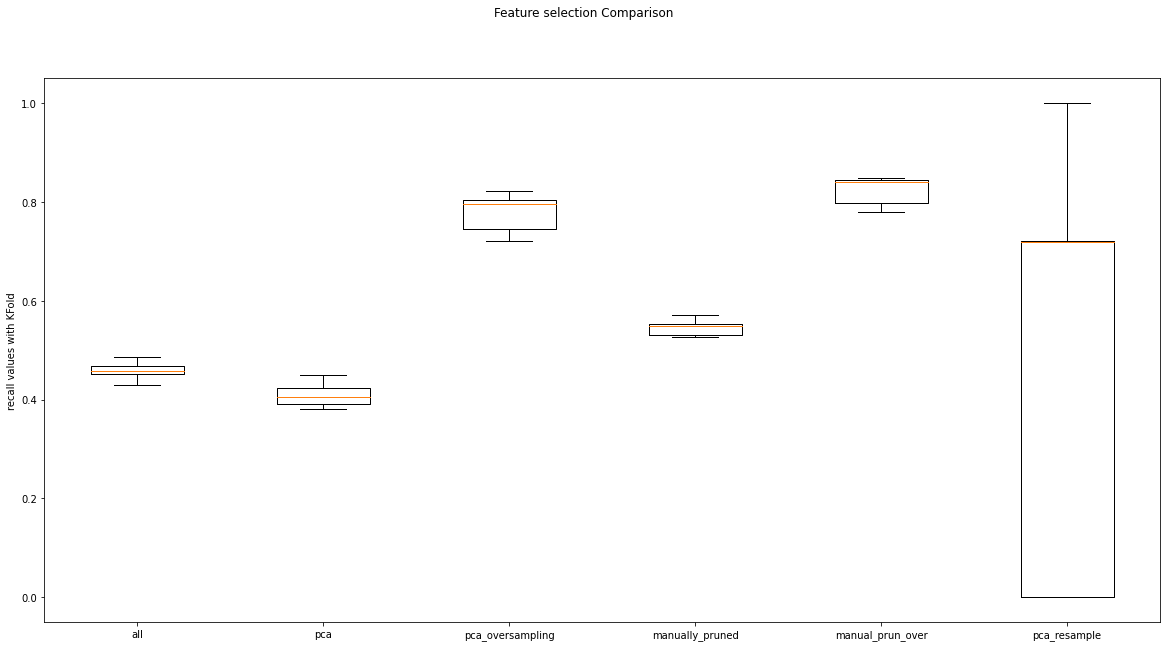

In [ ]:
# model comparison
seed = 7
num_folds = 10
data = []
data.append(('all',X_train, y_train))
data.append(('pca',Xpca_train, ypca_train))
data.append(('pca_oversampling', Xspca_train, yspca_train))
data.append(('manually_pruned', Xp_train, yp_train))
data.append(('manual_prun_over', Xsp_train, ysp_train))
#data.append(('pca_resample', Xupca_train, yu_train))
#models.append(('SVM', svm.SVC(), {'C': Cs}))
# evalutate each model in turn
results = []
names = []
for name, X_train,Y_train in data:
    model = LogisticRegression(C=10)
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure(figsize=(20,10))
fig.suptitle('Feature selection Comparison')
ax = fig.add_subplot(111)
plt.ylabel("recall values with KFold")
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   51.5s finished


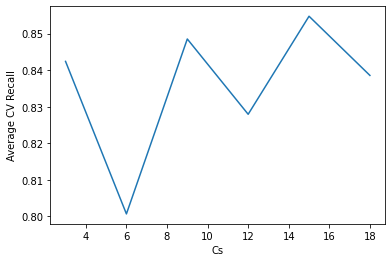

Best model on training set has {'n_neighbors': 15} with accuracy 0.8548
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     11360
           1       0.54      0.78      0.63      3700

    accuracy                           0.78     15060
   macro avg       0.73      0.78      0.74     15060
weighted avg       0.82      0.78      0.79     15060



In [ ]:
# baseline KNN
accuracies=[]
recalls=[]
ks = range(3,20,3)
param =  {'n_neighbors': ks}
clf = GridSearchCV(KNeighborsClassifier(), param_grid = param, cv = 5, verbose=True, n_jobs=-1, scoring='recall')
clf.fit(Xsp_train, ysp_train)
plt.plot(ks, clf.cv_results_['mean_test_score'])
plt.xlabel('Cs')
plt.ylabel('Average CV Recall')
plt.show()
print("Best model on training set has %r with accuracy %.4f" %(clf.best_params_, clf.best_score_))
y_true, y1_pred = yp_test, clf.predict(Xp_test)
print(classification_report(y_true, y1_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred,average='macro'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.2s finished


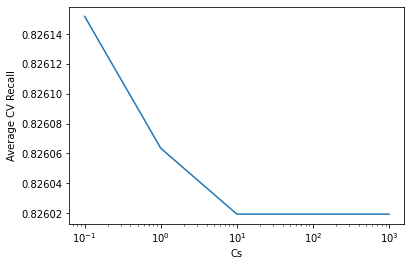

Best model with upsampling on training set has {'C': 0.1} with accuracy 0.8262
              precision    recall  f1-score   support

           0       0.93      0.77      0.85     11360
           1       0.54      0.83      0.66      3700

    accuracy                           0.79     15060
   macro avg       0.74      0.80      0.75     15060
weighted avg       0.84      0.79      0.80     15060



In [ ]:
# baseline Logistic Regression
Cs = [0.1, 1, 10, 100, 1000]
param =  {'C': Cs}
clf = GridSearchCV(LogisticRegression(), param_grid = param, cv = 5, verbose=True, n_jobs=-1, scoring='recall')
clf.fit(Xsp_train, ysp_train)
plt.plot(Cs, clf.cv_results_['mean_test_score'])
plt.xlabel('Cs')
plt.xscale('log')
plt.ylabel('Average CV Recall')
plt.show()
print("Best model with upsampling on training set has %r with accuracy %.4f" %(clf.best_params_, clf.best_score_))
y_true, y1_pred = yp_test, clf.predict(Xp_test)
print(classification_report(y_true, y1_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred,average='macro'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.6min finished


Best model on training set has {'C': 0.1} with accuracy 0.8262
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     11360
           1       0.57      0.79      0.66      3700

    accuracy                           0.80     15060
   macro avg       0.74      0.80      0.76     15060
weighted avg       0.83      0.80      0.81     15060



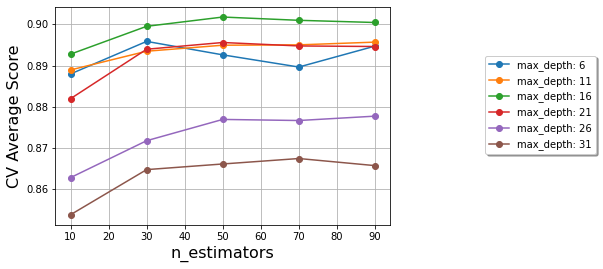

In [ ]:
# Random Forest
n_estimators = list(range(10,101,20))
#max_features = list(range(6,32,5))
max_depth = list(range(6,32,5))
#param_grid = {'n_estimators': n_estimators, 'max_features' : max_features}
param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth}
clf_for = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring = 'recall')
    
clf_for.fit(Xsp_train, ysp_train)

#plot_grid_search(clf_for.cv_results_, n_estimators, max_features, "n_estimators", "max_features")
plot_grid_search(clf_for.cv_results_, n_estimators, max_depth, "n_estimators", "max_depth")

print("Best model on training set has %r with accuracy %.4f" %(clf.best_params_, clf.best_score_))
y_true, y_pred = yp_test, clf_for.predict(Xp_test)
print(classification_report(y_true, y_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred, average='macro'))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


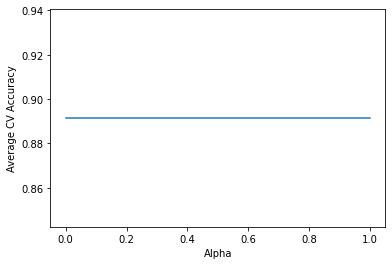

Best model on training set has {'alpha': 0} with recall 0.8914
              precision    recall  f1-score   support

           0       0.95      0.63      0.75     11360
           1       0.44      0.90      0.59      3700

    accuracy                           0.69     15060
   macro avg       0.69      0.76      0.67     15060
weighted avg       0.82      0.69      0.71     15060



In [ ]:
mm = MinMaxScaler()
alphas = [0, 0.001, 0.1,  0.3, 0.5, 0.7, 1]
Xmm_train = mm.fit_transform(Xsp_train)
Xmm_test = mm.transform(Xp_test)
param_grid = {'alpha': alphas}

clf_nai = GridSearchCV(MultinomialNB(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')
    
clf_nai.fit(Xmm_train, ysp_train)

plt.plot(alphas, clf_nai.cv_results_['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('Average CV Accuracy')
plt.show()

print("Best model on training set has %r with recall %.4f" %(clf_nai.best_params_, clf_nai.best_score_))
y_true, y_pred = yp_test, clf_nai.predict(Xmm_test)
print(classification_report(y_true, y_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred, average='macro'))

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.3min finished


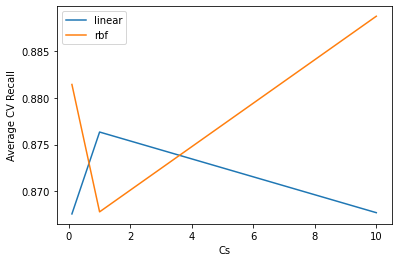

Best model on training set has {'C': 10, 'kernel': 'rbf'} with accuracy 0.8887
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     11360
           1       0.52      0.86      0.65      3700

    accuracy                           0.77     15060
   macro avg       0.73      0.80      0.74     15060
weighted avg       0.84      0.77      0.79     15060



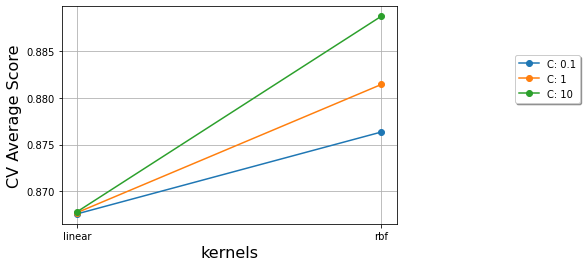

In [ ]:
Cs = [0.1, 1, 10]
kernels=['linear','rbf']
param_grid = {'kernel': kernels, 'C': Cs}
clf_svm = GridSearchCV(svm.SVC(), param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1, scoring = 'recall')
    
clf_svm.fit(Xsp_train, ysp_train)

plt.plot(Cs, clf_svm.cv_results_['mean_test_score'][:3], label='linear')
plt.plot(Cs, clf_svm.cv_results_['mean_test_score'][3:6], label='rbf')
plt.xlabel('Cs')
plt.legend()
plt.ylabel('Average CV Recall')
plt.show()
#plot_grid_search(clf_for.cv_results_, n_estimators, max_features, "n_estimators", "max_features")
plot_grid_search(clf_svm.cv_results_, kernels, Cs, "kernels", "C")

print("Best model on training set has %r with accuracy %.4f" %(clf_svm.best_params_, clf_svm.best_score_))
y_true, y_pred = yp_test, clf_svm.predict(Xp_test)
print(classification_report(y_true, y_pred))
accuracies.append(accuracy_score(y_true, y_pred))
recalls.append(recall_score(y_true, y_pred,average='macro'))

# Tests

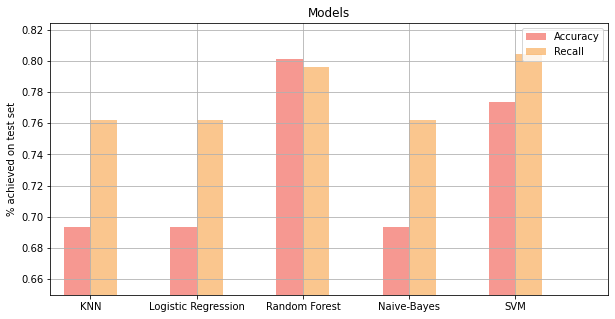

In [ ]:
# Setting the positions and width for the bars
pos = list(range(len(accuracies))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        accuracies, 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label="Acc#uracy") 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        recalls,
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label="Recall") 

# Set the y axis label
ax.set_ylabel('% achieved on test set')

# Set the chart's title
ax.set_title('Models')

# Set the position of the x ticks
ax.set_xticks([p+ 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(["KNN","Logistic Regression","Random Forest", "Naive-Bayes", "SVM"])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0.65, max(accuracies + recalls)+0.02] )

# Adding the legend and showing the plot
plt.legend(['Accuracy', 'Recall'] ,loc='upper right')
plt.grid()
plt.show()